In [1]:
import sys
sys.path.append('/home/jupyter/trials/IDM-VTON/')
from PIL import Image
from src.tryon_pipeline import StableDiffusionXLInpaintPipeline as TryonPipeline

from src.unet_hacked_garmnet import UNet2DConditionModel as UNet2DConditionModel_ref
from src.unet_hacked_tryon import UNet2DConditionModel
from transformers import (

    CLIPImageProcessor,
    CLIPVisionModelWithProjection,
    CLIPTextModel,
    CLIPTextModelWithProjection,
)
from diffusers import DDPMScheduler,AutoencoderKL
from typing import List

import torch
import os

from transformers import AutoTokenizer
import numpy as np
from utils_mask import get_mask_location
from torchvision import transforms
import apply_net
from preprocess.humanparsing.run_parsing import Parsing
from preprocess.openpose.run_openpose import OpenPose
from detectron2.data.detection_utils import convert_PIL_to_numpy,_apply_exif_orientation
from torchvision.transforms.functional import to_pil_image


/home/boris_martirosyan/.conda/envs/idm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

def pil_to_binary_mask(pil_image, threshold=0):
    np_image = np.array(pil_image)
    grayscale_image = Image.fromarray(np_image).convert("L")
    binary_mask = np.array(grayscale_image) > threshold
    mask = np.zeros(binary_mask.shape, dtype=np.uint8)
    for i in range(binary_mask.shape[0]):
        for j in range(binary_mask.shape[1]):
            if binary_mask[i,j] == True :
                mask[i,j] = 1
    mask = (mask*255).astype(np.uint8)
    output_mask = Image.fromarray(mask)
    return output_mask


base_path = 'yisol/IDM-VTON'
#example_path = os.path.join(os.path.dirname(__file__), 'example')

unet = UNet2DConditionModel.from_pretrained(
    base_path,
    subfolder="unet",
    torch_dtype=torch.float16,
)
unet.requires_grad_(False)
tokenizer_one = AutoTokenizer.from_pretrained(
    base_path,
    subfolder="tokenizer",
    revision=None,
    use_fast=False,
)
tokenizer_two = AutoTokenizer.from_pretrained(
    base_path,
    subfolder="tokenizer_2",
    revision=None,
    use_fast=False,
)
noise_scheduler = DDPMScheduler.from_pretrained(base_path, subfolder="scheduler")

text_encoder_one = CLIPTextModel.from_pretrained(
    base_path,
    subfolder="text_encoder",
    torch_dtype=torch.float16,
)
text_encoder_two = CLIPTextModelWithProjection.from_pretrained(
    base_path,
    subfolder="text_encoder_2",
    torch_dtype=torch.float16,
)
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    base_path,
    subfolder="image_encoder",
    torch_dtype=torch.float16,
    )
vae = AutoencoderKL.from_pretrained(base_path,
                                    subfolder="vae",
                                    torch_dtype=torch.float16,
)

# "stabilityai/stable-diffusion-xl-base-1.0",
UNet_Encoder = UNet2DConditionModel_ref.from_pretrained(
    base_path,
    subfolder="unet_encoder",
    torch_dtype=torch.float16,
)
print('loaded')


parsing_model = Parsing(0)
openpose_model = OpenPose(0)

UNet_Encoder.requires_grad_(False)
image_encoder.requires_grad_(False)
vae.requires_grad_(False)
unet.requires_grad_(False)
text_encoder_one.requires_grad_(False)
text_encoder_two.requires_grad_(False)
tensor_transfrom = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
    )

pipe = TryonPipeline.from_pretrained(
        base_path,
        unet=unet,
        vae=vae,
        feature_extractor= CLIPImageProcessor(),
        text_encoder = text_encoder_one,
        text_encoder_2 = text_encoder_two,
        tokenizer = tokenizer_one,
        tokenizer_2 = tokenizer_two,
        scheduler = noise_scheduler,
        image_encoder=image_encoder,
        torch_dtype=torch.float16,
)
pipe.unet_encoder = UNet_Encoder



cuda:0
============= https://huggingface.co/yisol/IDM-VTON/resolve/main/unet/config.json
============= https://huggingface.co/yisol/IDM-VTON/resolve/585a32e74aee241cbc0d0cc3ab21392ca58c916a/unet/diffusion_pytorch_model.safetensors


/home/boris_martirosyan/.conda/envs/idm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


============= https://huggingface.co/yisol/IDM-VTON/resolve/main/tokenizer/tokenizer_config.json
============= https://huggingface.co/yisol/IDM-VTON/resolve/main/tokenizer_2/tokenizer_config.json
============= https://huggingface.co/yisol/IDM-VTON/resolve/main/scheduler/scheduler_config.json


/home/boris_martirosyan/.conda/envs/idm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


============= https://huggingface.co/yisol/IDM-VTON/resolve/main/text_encoder/config.json
============= https://huggingface.co/yisol/IDM-VTON/resolve/main/text_encoder/config.json
============= https://huggingface.co/yisol/IDM-VTON/resolve/main/text_encoder_2/config.json
============= https://huggingface.co/yisol/IDM-VTON/resolve/main/text_encoder_2/config.json
============= https://huggingface.co/yisol/IDM-VTON/resolve/main/image_encoder/config.json
============= https://huggingface.co/yisol/IDM-VTON/resolve/main/image_encoder/config.json
============= https://huggingface.co/yisol/IDM-VTON/resolve/main/vae/config.json
============= https://huggingface.co/yisol/IDM-VTON/resolve/main/unet_encoder/config.json


Some weights of the model checkpoint were not used when initializing UNet2DConditionModel: 
 ['add_embedding.linear_1.bias, add_embedding.linear_1.weight, add_embedding.linear_2.bias, add_embedding.linear_2.weight']


loaded
============= https://huggingface.co/yisol/IDM-VTON/resolve/main/model_index.json


Loading pipeline components...: 100%|██████████| 8/8 [00:00<00:00, 73.89it/s]


In [3]:
from PIL import Image
import numpy as np
import cv2

def refine_mask(mask):
    contours, hierarchy = cv2.findContours(mask.astype(np.uint8),
                                           cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_L1)
    area = []
    for j in range(len(contours)):
        a_d = cv2.contourArea(contours[j], True)
        area.append(abs(a_d))
    refine_mask = np.zeros_like(mask).astype(np.uint8)
    if len(area) != 0:
        i = area.index(max(area))
        cv2.drawContours(refine_mask, contours, i, color=255, thickness=-1)

    return refine_mask

def mask_f(original_image_path, mask_path):
    original_image = Image.open(original_image_path).convert('RGBA')
    mask_image = Image.open(mask_path).convert('L')

    # Resize images to 768x1024
    original_image = original_image.resize((768, 1024))
    mask_image = mask_image.resize((768, 1024))

    # Create an alpha mask from the grayscale mask
    alpha_mask = mask_image.point(lambda x: 255 if x > 0 else 0)  # Convert grayscale to binary (0 or 255)

    # Create a new RGBA mask image using the alpha mask
    rgba_mask = Image.new('RGBA', mask_image.size)
    rgba_mask.putalpha(alpha_mask)

    # Convert RGBA mask to grayscale with 127 value for the mask regions
    rgba_mask_np = np.array(rgba_mask)
    gray_mask_np = (rgba_mask_np[:, :, 3] / 2).astype(np.uint8)  # Divide by 2 to convert 255 to 127

    # Create the gray mask image
    mask_gray = Image.fromarray(gray_mask_np, mode='L')

    # Combine the original image with the gray mask using the alpha channel of the mask
    mask_combined = Image.composite(original_image, Image.new('RGBA', original_image.size, (127, 127, 127, 127)), alpha_mask)

    return mask_image, mask_gray, mask_combined


In [8]:
def start_tryon(dict,garm_img,garment_des,is_checked,is_checked_crop,denoise_steps,seed, mask_path):
    
    openpose_model.preprocessor.body_estimation.model.to(device)
    pipe.to(device)
    pipe.unet_encoder.to(device)

    garm_img = Image.open(garm_img).convert("RGB").resize((768,1024))
    human_img_orig = Image.open(dict["background"]).convert("RGB")   
    print(f'orige size : {human_img_orig.size}') 
    human_img_size = human_img_orig.size
    if is_checked_crop:
        width, height = human_img_orig.size
        target_width = int(min(width, height * (3 / 4)))
        target_height = int(min(height, width * (4 / 3)))
        left = (width - target_width) / 2
        top = (height - target_height) / 2
        right = (width + target_width) / 2
        bottom = (height + target_height) / 2
        cropped_img = human_img_orig.crop((left, top, right, bottom))
        crop_size = cropped_img.size
        human_img = cropped_img.resize((768,1024))
    else:
        human_img = human_img_orig.resize((768,1024))


    if is_checked:
        keypoints = openpose_model(human_img.resize((384,512)))
        model_parse, _ = parsing_model(human_img.resize((384,512)))
        #mask, mask_gray = get_mask_location('hd', "upper_body", model_parse, keypoints)


        #mask = Image.fromarray(np.array(mask).astype(np.uint8) * 127)
        mask = Image.open(mask_path) # .resize(human_img_size)
        print(mask.size, human_img_size)
        mask_gray = Image.open(mask_path) #.resize(human_img_size)
        mask_gray = Image.fromarray(np.array(mask_gray).astype(np.uint8) * 127) #.resize(human_img_size)

        mask = mask.resize((768,1024))
    else:
        mask = pil_to_binary_mask(dict['layers'][0].convert("RGB")) #.resize((768, 1024))
        # mask = transforms.ToTensor()(mask)
        # mask = mask.unsqueeze(0)
    print(mask.size, human_img.size)
    mask_gray = (1-transforms.ToTensor()(mask)) * tensor_transfrom(human_img)
    mask_gray = to_pil_image((mask_gray+1.0)/2.0)

    #return mask_gray

    human_img_arg = _apply_exif_orientation(human_img.resize((384,512)))
    human_img_arg = convert_PIL_to_numpy(human_img_arg, format="BGR")
     
    

    args = apply_net.create_argument_parser().parse_args(('show', '/home/jupyter/trials/IDM-VTON/configs/densepose_rcnn_R_50_FPN_s1x.yaml', '/home/jupyter/trials/IDM-VTON/ckpt/densepose/model_final_162be9.pkl', 'dp_segm', '-v', '--opts', 'MODEL.DEVICE', 'cuda'))
    # verbosity = getattr(args, "verbosity", None)
    pose_img = args.func(args,human_img_arg)    
    pose_img = pose_img[:,:,::-1]    
    pose_img = Image.fromarray(pose_img).resize((768,1024))
    
    with torch.no_grad():
        # Extract the images
        with torch.cuda.amp.autocast():
            with torch.no_grad():
                prompt = "model is wearing " + garment_des
                negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"
                with torch.inference_mode():
                    (
                        prompt_embeds,
                        negative_prompt_embeds,
                        pooled_prompt_embeds,
                        negative_pooled_prompt_embeds,
                    ) = pipe.encode_prompt(
                        prompt,
                        num_images_per_prompt=1,
                        do_classifier_free_guidance=True,
                        negative_prompt=negative_prompt,
                    )
                                    
                    prompt = "a photo of " + garment_des
                    negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality, blue lines in chest"
                    if not isinstance(prompt, List):
                        prompt = [prompt] * 1
                    if not isinstance(negative_prompt, List):
                        negative_prompt = [negative_prompt] * 1
                    with torch.inference_mode():
                        (
                            prompt_embeds_c,
                            _,
                            _,
                            _,
                        ) = pipe.encode_prompt(
                            prompt,
                            num_images_per_prompt=1,
                            do_classifier_free_guidance=False,
                            negative_prompt=negative_prompt,
                        )


                    #print(human_img.size, mask.size())
                    pose_img =  tensor_transfrom(pose_img).unsqueeze(0).to(device,torch.float16)
                    garm_tensor =  tensor_transfrom(garm_img).unsqueeze(0).to(device,torch.float16)
                    generator = torch.Generator(device).manual_seed(seed) if seed is not None else None
                    images = pipe(
                        prompt_embeds=prompt_embeds.to(device,torch.float16),
                        negative_prompt_embeds=negative_prompt_embeds.to(device,torch.float16),
                        pooled_prompt_embeds=pooled_prompt_embeds.to(device,torch.float16),
                        negative_pooled_prompt_embeds=negative_pooled_prompt_embeds.to(device,torch.float16),
                        num_inference_steps=denoise_steps,
                        generator=generator,
                        strength = 1.0,
                        pose_img = pose_img.to(device,torch.float16),
                        text_embeds_cloth=prompt_embeds_c.to(device,torch.float16),
                        cloth = garm_tensor.to(device,torch.float16),
                        mask_image=mask,
                        image=human_img, 
                        height=1024,
                        width=768,
                        ip_adapter_image = garm_img.resize((768,1024)),
                        guidance_scale=2.0,
                    )[0]

    images[0].save("first.png")
    if is_checked_crop:
        out_img = images[0].resize(crop_size)        
        human_img_orig.paste(out_img, (int(left), int(top)))    
        return human_img_orig, mask_gray
    else:
        return images[0], mask_gray
    # return images[0], mask_gray
    

In [12]:
ans = start_tryon(dict = {"background" : "/home/jupyter/person_back.png"}, 
            garm_img = "/home/jupyter/trials/IDM-VTON/gradio_demo/15.png", 
            garment_des = "White t-shirt, written Love Age, Bright colors",#
            is_checked=True, 
            is_checked_crop=False, 
            denoise_steps=30, 
            seed=0,
            mask_path = "/home/jupyter/person_back_mask.png"
            )
ans

orige size : (1024, 1024)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


(1024, 1024) (1024, 1024)
(768, 1024) (768, 1024)


100%|██████████| 30/30 [00:18<00:00,  1.61it/s]


(<PIL.Image.Image image mode=RGB size=768x1024>,
 <PIL.Image.Image image mode=RGB size=768x1024>)

(768, 1024) (768, 1024)


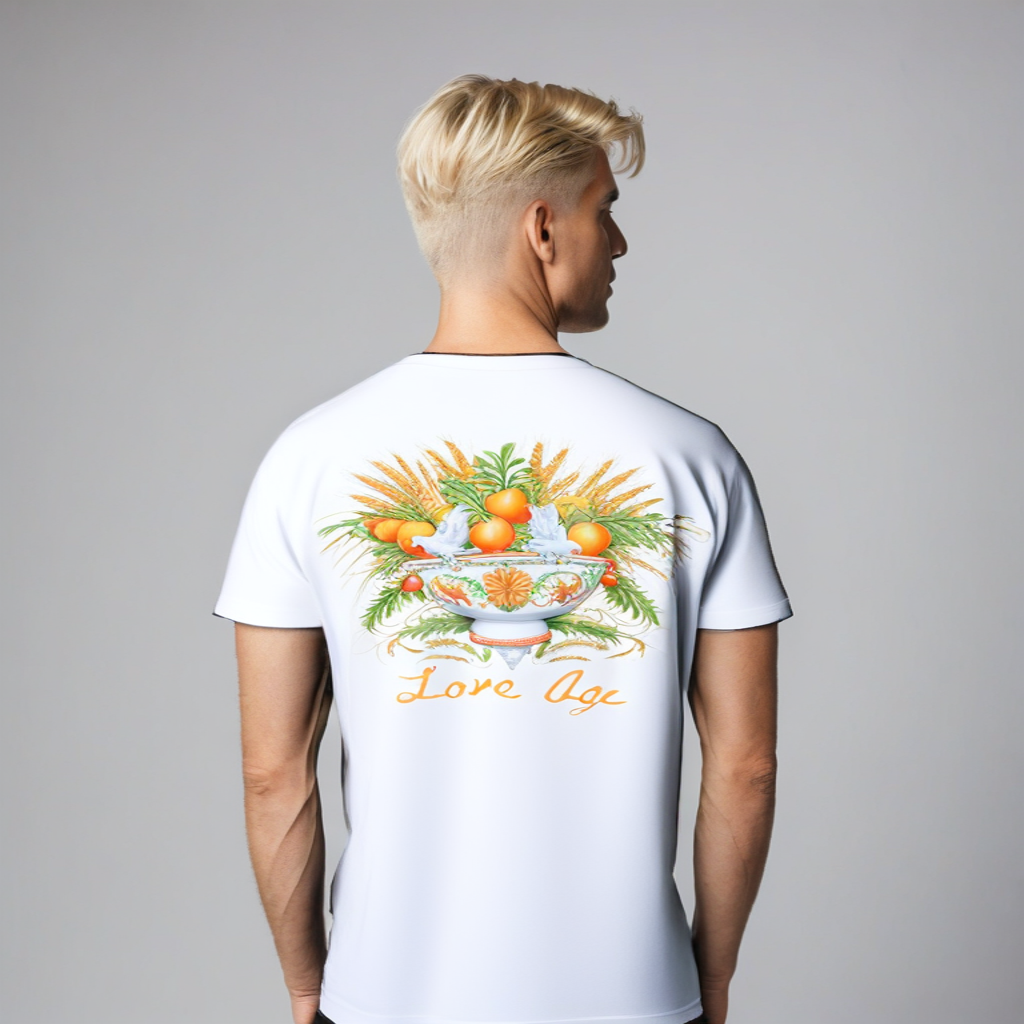

In [13]:
print(ans[0].size, ans[1].size)
#ans[0].save('aurora_ser.png')
ans[0].resize((1024, 1024))

((1164, 1800), (832, 1280))